# Binomial Option Pricing

In [1]:
import numpy as np
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
from labellines import labelLines
from scipy.stats import binom
from scipy.stats import norm

### Define Option Details 

In [2]:
interest = 0.04
numPeriods = 6
optionType = "Call"
# optionType = "Put"
timeToExpiration = 1
vol = 0.04
up = np.round(np.exp(vol * np.sqrt(timeToExpiration / numPeriods)), 4) # Define the size of an up movement in terms of implied volatility
down = 1/up
spot = 100
strike = 104

# Probability of an up movement by the assumption it is a risk-neutral world
p = ((1 + interest*(timeToExpiration/numPeriods)) - down) / (up - down)

## Create binomial tree for the underlying price of the option

In [3]:

def create_level(previousLevel, up, down):
    newLevel = []
    for i in previousLevel:
        newLevel.append(i * down)
    newLevel.append(previousLevel[-1]*up)
    return newLevel

def create_pricing_tree(spot, up, down, numPeriods):
    pricingTree = [[spot]]
    count = 1
    while count <= numPeriods:
        pricingTree.append(create_level(pricingTree[-1], up, down))
        count = count + 1
    return pricingTree

def plot_pricing_tree(pricingTree):
    numPeriods = len(pricingTree) - 1
    mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)

    for i in range(numPeriods+1):
                value = pricingTree[i]
                rows = np.zeros(i+1, dtype=np.int16) + i
                cols = np.arange(i+1)*2+numPeriods-i
                mat[rows, cols] = value

    fig = plt.figure(figsize=[15, 7])
    plt.axis('off')
    plt.title('')

    for i in range(numPeriods):
        x = (np.arange(3 + i*2) % 2 == 0) + i
        y = np.arange(0, 2*(i+1)+1) - 1 + (numPeriods-i)
        v = mat[x, y].toarray()[0]
        plt.plot(x, v, 'bo-')
        for i in range(len(x)- 1):
            plt.text((x[i] + x[i+1]) / 2, (v[i] + v[i+1]) / 2, f'{1 - abs(((i % 2) - p)):.2f}', fontsize=12, ha='center', va='bottom')
    
        for xi, vi in zip(x, v):
            plt.text(xi, vi, f'{vi:.2f}', fontsize=12, ha='center', va='bottom', bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

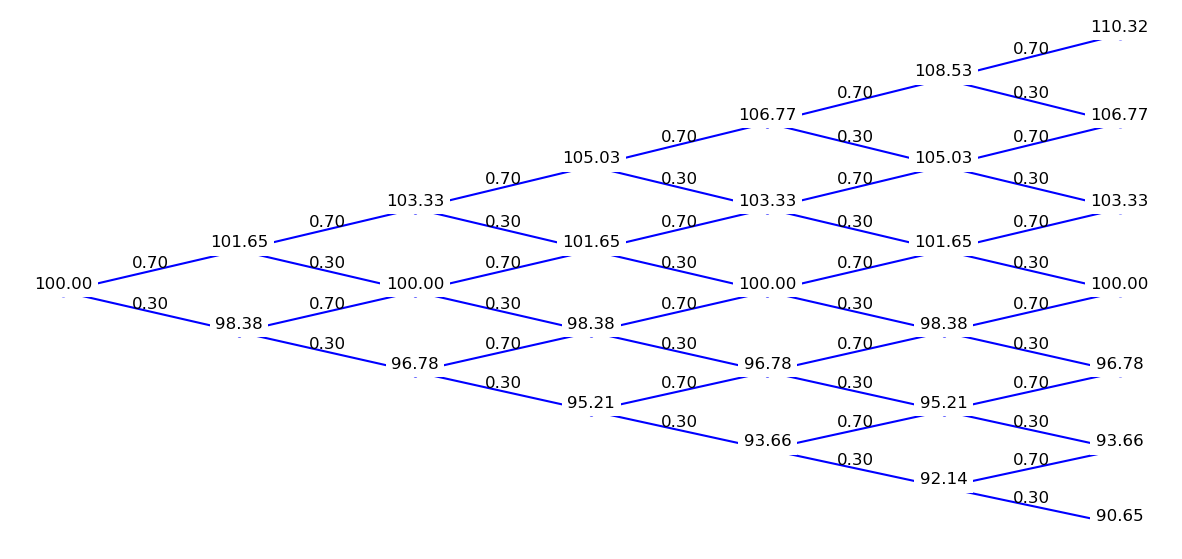

In [4]:
pricingTree = create_pricing_tree(spot, up, down, numPeriods)
plot_pricing_tree(pricingTree)

## Create binomial tree with the option value at any point
At expiration the option is worth exactly its intrinsic value.

S - Underlying Price \
X - Strike Price

For a call:\
&emsp; maximum(S - X, 0)

For a put:\
&emsp; maximum(X - S, 0)

By propagating the price of the option at exercise back through the tree the present value for the option can be calculated.

In [5]:
def create_call_value_level(previousLevel, p, interest, timeToExpiration, numPeriods):
    newLevel = []
    for i in range(len(previousLevel) - 1):
        newLevel.append(((1-p) * previousLevel[i] + p * previousLevel[i+1]) / (1+(interest*timeToExpiration/numPeriods)))
    return newLevel

def create_call_value_tree(pricingTreeLastLevel, strike, p, interest, timeToExpiration, numPeriods):
    call_value_tree = []
    currentLevel = [max(0, item - strike) for item in pricingTreeLastLevel]
    while(len(currentLevel) > 0):
        call_value_tree.append(currentLevel)
        currentLevel = create_call_value_level(currentLevel, p, interest, timeToExpiration, numPeriods)
    call_value_tree.reverse()
    return call_value_tree

def plot_call_value_tree(pricingTree, call_value_tree):
    numPeriods = len(pricingTree) - 1
    mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)
    call_mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)
    for i in range(numPeriods+1):
                value = pricingTree[i]
                call_value = call_value_tree[i]
                rows = np.zeros(i+1, dtype=np.int16) + i
                cols = np.arange(i+1)*2+numPeriods-i
                mat[rows, cols] = value
                call_mat[rows, cols] = call_value

    fig = plt.figure(figsize=[15, 7])
    plt.axis('off')
    plt.title('Tree')

    for i in range(numPeriods):
        x = (np.arange(3 + i*2) % 2 == 0) + i
        y = np.arange(0, 2*(i+1)+1) - 1 + (numPeriods-i)
        v = mat[x, y].toarray()[0]
        call_v = call_mat[x, y].toarray()[0]
        plt.plot(x, v, 'bo-')
        for i in range(len(x)- 1):
            plt.text((x[i] + x[i+1]) / 2, (v[i] + v[i+1]) / 2, f'{1 - abs(((i % 2) - p)):.2f}', fontsize=12, ha='center', va='bottom',)


        for xi, vi, ci in zip(x, v, call_v):
            plt.text(xi, vi, f'{vi:.2f}\n{ci:.2f}', fontsize=12, ha='center', va='bottom', bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

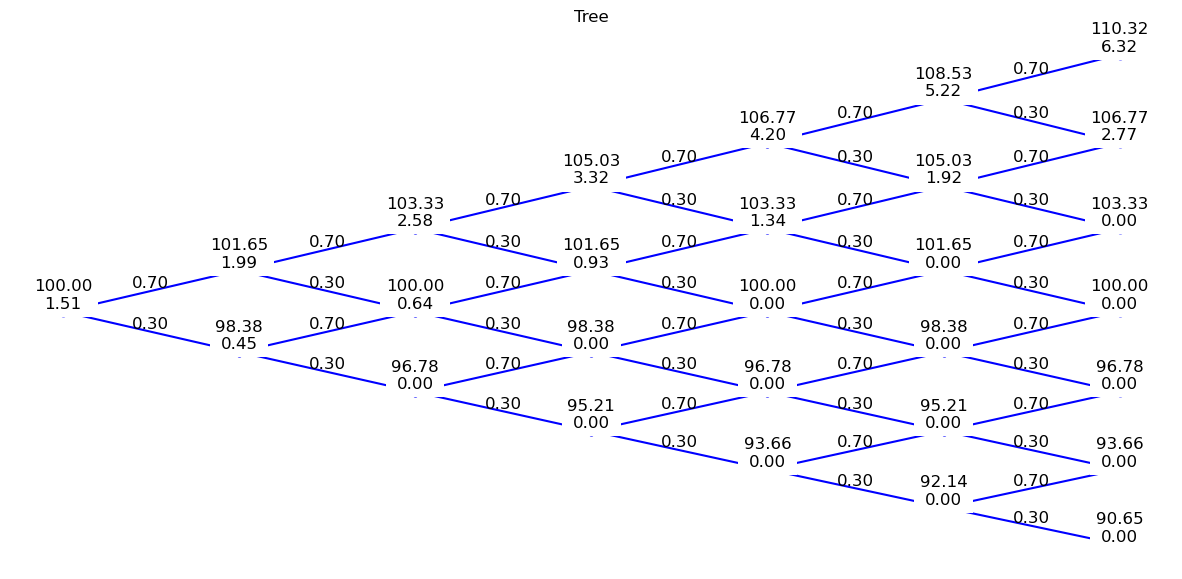

In [6]:
call_value_tree = create_call_value_tree(pricingTree[-1], strike, p, interest, timeToExpiration, numPeriods)
plot_call_value_tree(pricingTree, call_value_tree)

## Calculate the value of delta for each point in the binomial tree
The delta is the change in the option's value with respect to movement in the price of the underlying contract. We can express this as a fraction Δ = $\frac{C_{up} - C_{down}}{S_{up} - S_{down}}$

In [7]:
def create_delta_tree(pricingTree, call_value_tree):
    delta_tree = []
    for i in range(1, len(pricingTree)):
        priceTree = pricingTree[i]
        callTree = call_value_tree[i]
        currentLevel = []
        for j in range(i):
            currentLevel.append((callTree[j+1] - callTree[j]) / (priceTree[j+1] - priceTree[j])  * 100)
        delta_tree.append(currentLevel)
    return delta_tree

def plot_delta_tree(pricingTree, call_value_tree, delta_tree):
    numPeriods = len(pricingTree) - 1
    mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)
    call_mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)
    delta_mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)
    for i in range(numPeriods+1):
                value = pricingTree[i]
                call_value = call_value_tree[i]
                rows = np.zeros(i+1, dtype=np.int16) + i
                cols = np.arange(i+1)*2+numPeriods-i
                mat[rows, cols] = value
                call_mat[rows, cols] = call_value
                if i == numPeriods:
                    break
                delta_value = delta_tree[i]
                delta_mat[rows, cols] = delta_value
    fig = plt.figure(figsize=[15, 7])
    plt.axis('off')
    plt.title('Tree')

    for i in range(numPeriods):
        x = (np.arange(3 + i*2) % 2 == 0) + i
        y = np.arange(0, 2*(i+1)+1) - 1 + (numPeriods-i)
        v = mat[x, y].toarray()[0]
        call_v = call_mat[x, y].toarray()[0]
        delta_v = delta_mat[x,y].toarray()[0]
        plt.plot(x, v, 'bo-')
        for j in range(len(x)- 1):
            plt.text((x[j] + x[j+1]) / 2, (v[j] + v[j+1]) / 2, f'{1 - abs(((j % 2) - p)):.2f}', fontsize=12, ha='center', va='bottom',)

        for j in range(len(x)):
            if i == numPeriods - 1  and j % 2 == 0:
                plt.text(x[j], v[j], f'{call_v[j]:.2f}', fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=1, edgecolor='none'))
            else:
                plt.text(x[j], v[j], f'{v[j]:.2f}\n{call_v[j]:.2f}\nΔ = {delta_v[j]:.0f}', fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=1, edgecolor='none'))
        

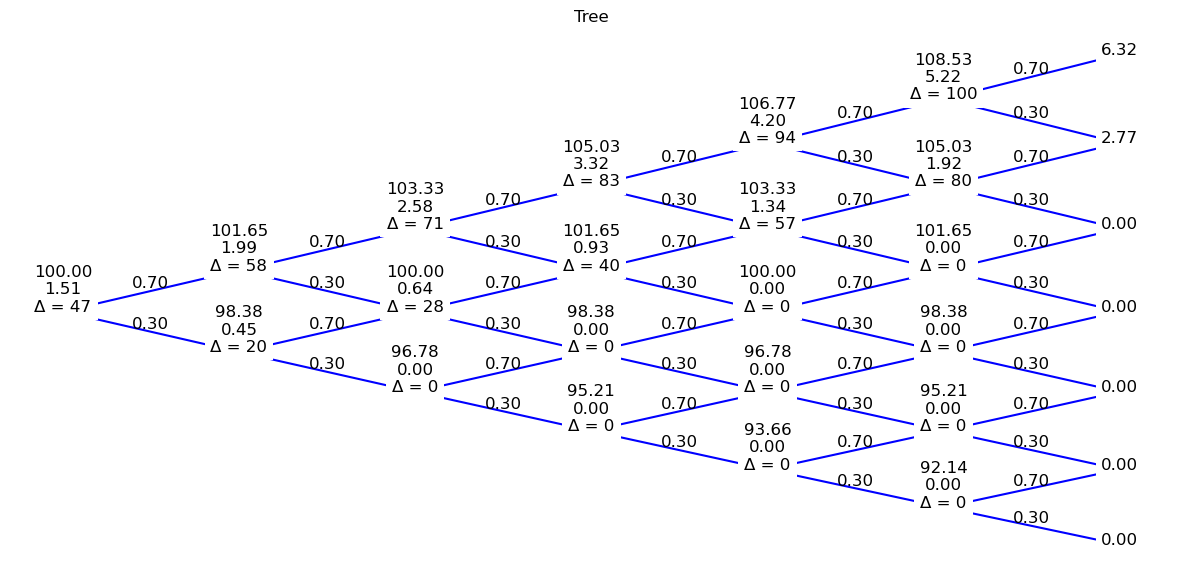

In [9]:

delta_tree = create_delta_tree(pricingTree, call_value_tree)
plot_delta_tree(pricingTree, call_value_tree, delta_tree)

## A function to plot a binomial tree with optional call and delta values

In [10]:
def plot_tree(pricingTree, call_value_tree=None, delta_tree=None):
    numPeriods = len(pricingTree) - 1
    mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)
    call_mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)
    delta_mat = lil_matrix((numPeriods+1, numPeriods*2+1), dtype = np.float32)
    for i in range(numPeriods+1):
                value = pricingTree[i]
                rows = np.zeros(i+1, dtype=np.int16) + i
                cols = np.arange(i+1)*2+numPeriods-i
                mat[rows, cols] = value
                if call_value_tree is not None:
                    call_value = call_value_tree[i]
                    call_mat[rows, cols] = call_value
                if delta_tree is None:
                    continue
                if i == numPeriods:
                    break
                delta_value = delta_tree[i]
                delta_mat[rows, cols] = delta_value
    fig = plt.figure(figsize=[15, 7])
    plt.axis('off')
    plt.title('Tree')

    for i in range(numPeriods):
        x = (np.arange(3 + i*2) % 2 == 0) + i
        y = np.arange(0, 2*(i+1)+1) - 1 + (numPeriods-i)
        v = mat[x, y].toarray()[0]
        call_v = call_mat[x, y].toarray()[0]
        delta_v = delta_mat[x,y].toarray()[0]
        plt.plot(x, v, 'bo-')
        for j in range(len(x)- 1):
            plt.text((x[j] + x[j+1]) / 2, (v[j] + v[j+1]) / 2, f'{1 - abs(((j % 2) - p)):.2f}', fontsize=12, ha='center', va='bottom',)

        for j in range(len(x)):
            string = f'{v[j]:.2f}'
            if call_value_tree is not None:
                    string += f'\n{call_v[j]:.2f}'
            if not (i == numPeriods - 1  and j % 2 == 0):
                if delta_tree is not None: 
                    string += f'\nΔ = {delta_v[j]:.0f}'
            plt.text(x[j], v[j], string, fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

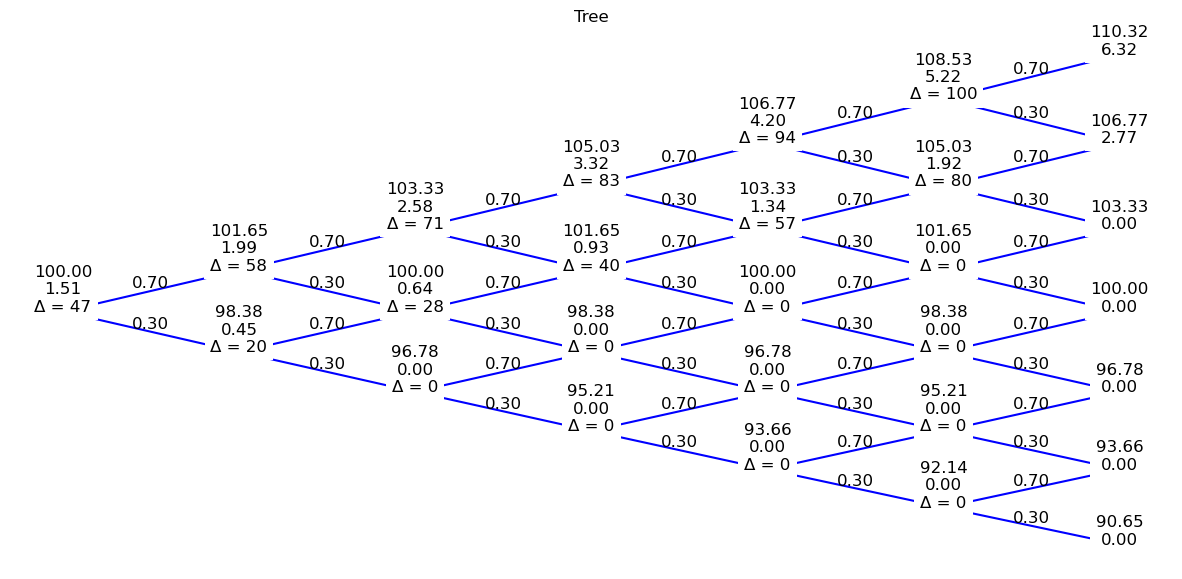

In [11]:
plot_tree(pricingTree, delta_tree=delta_tree, call_value_tree=call_value_tree)

## Black-Scholes model for calculating an option's price

In [19]:
N = norm.cdf

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)
print("Option Value:", round(BS_CALL(spot, strike, timeToExpiration, interest, vol), 2))

Option Value: 1.63


## Comparing the value obtained by the binomial option pricing method and Black-Scholes method for different time periods

In [13]:
values = []
maxPeriods = 250
for i in range(2, maxPeriods):
    dt = timeToExpiration / i
    vol = 0.04
    up = np.exp(vol * np.sqrt(dt))
    down = 1 / up
    pricingTree = create_pricing_tree(spot, up, down, i)
    p = ((1 + interest*(timeToExpiration/i)) - down) / (up - down)
    call_value_tree = create_call_value_tree(pricingTree[-1], strike, p, interest, timeToExpiration, i)
    values.append(call_value_tree[0][0])

bs_value = BS_CALL(spot, strike, timeToExpiration, interest, vol)

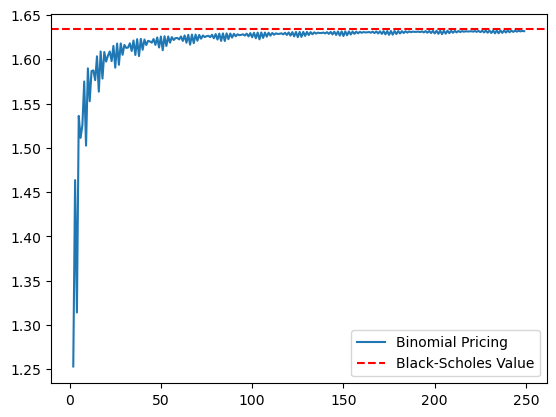

In [14]:
plt.plot(range(2,maxPeriods), values, label="Binomial Pricing")
plt.axhline(y=bs_value, color='r', linestyle='--', label="Black-Scholes Value")
plt.legend()
plt.show()

## Calculating the option's price using the binomial distribution

In [23]:
interest = 0.04
numPeriods = 300
optionType = "Call"
# optionType = "Put"
timeToExpiration = 1
dt = timeToExpiration / numPeriods
vol = 0.04
up = np.round(np.exp(vol * np.sqrt(dt)), 4)
# up = 1.05
down = 1/up
spot = 100
strike = 104
p = ((1 + interest*(timeToExpiration/numPeriods)) - down) / (up - down)


# Parameters
n = numPeriods
# Range of possible number of successes
x = np.arange(0, n+1)

# Probability mass function (PMF)
pmf = binom.pmf(x, n, p)
pricingTree = create_pricing_tree(spot, up, down, numPeriods)
p = ((1 + interest*(timeToExpiration/numPeriods)) - down) / (up - down)
call_value_tree = create_call_value_tree(pricingTree[-1], strike, p, interest, timeToExpiration, numPeriods)
total = 0
for prob, val in zip(pmf, call_value_tree[-1]):
    total += prob * val

## Visualising the probability and the option's intrinsic value against the option's underlying price

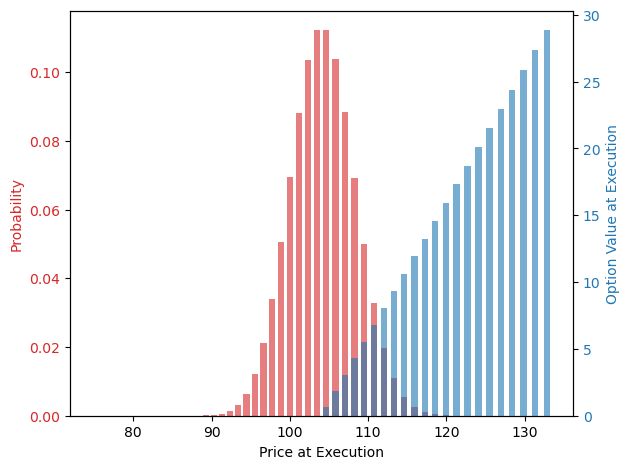

In [24]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Price at Execution')
ax1.set_ylabel('Probability', color=color)
ax1.bar(pricingTree[-1], pmf, color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Option Value at Execution', color=color)  # we already handled the x-label with ax1
ax2.bar(pricingTree[-1], call_value_tree[-1], color=color, alpha=0.6)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Multiplying the two distributions to obtain expected value from each underlying price at exercise

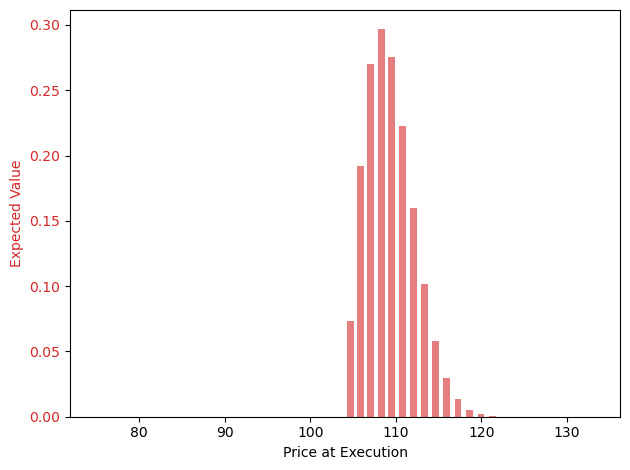

The area of the distribution is: 1.70


In [25]:
total = 0
resultList = []
for prob, val in zip(pmf, call_value_tree[-1]):
    resultList.append(prob*val)
    total += prob * val

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Price at Execution')
ax1.set_ylabel('Expected Value', color=color)
ax1.bar(pricingTree[-1], resultList, color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.show()

print("The area of the distribution is:", f'{total:.2f}')